<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

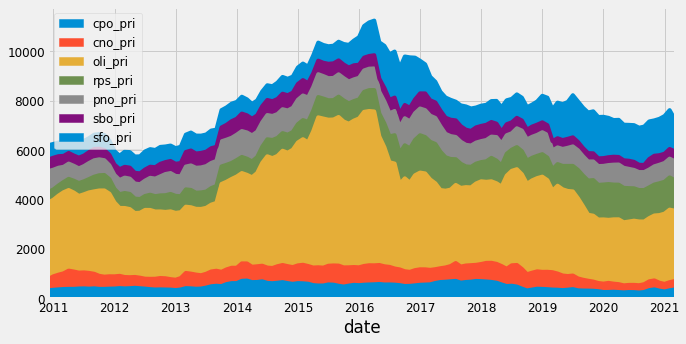

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [11]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [12]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [13]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [14]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [15]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [16]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [17]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [18]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/100
2/2 [==============================] - 8s 211ms/step - loss: 0.4236 - mse: 0.4236 - val_loss: 0.4072 - val_mse: 0.4072
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1441 - mse: 0.1441 - val_loss: 0.1456 - val_mse: 0.1456
Epoch 3/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 5/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 6/100
2/2 [==============================] - 0s 23ms/step - loss: 0.1015 - mse: 0.1015 - val_loss: 0.0565 - val_mse: 0.0565
Epoch 7/100
2/2 [==============================] - 0s 23ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 8/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0417 - mse: 0.0

[0.019830243661999702, 0.019830243661999702]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


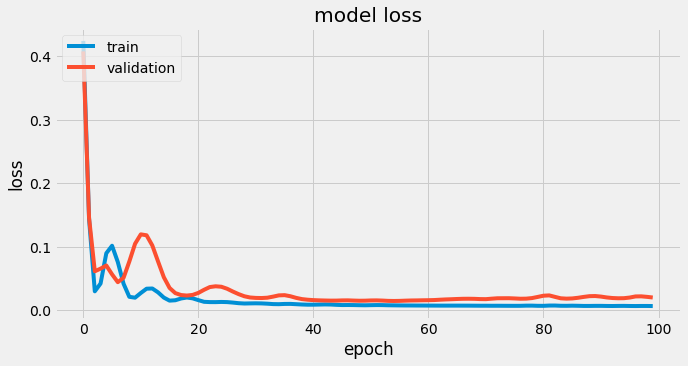

In [19]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0198 - mse: 0.0198


####Baseline MSE = 0.01660

In [ ]:
cnn_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 2, 64)             960       
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 64)                0         
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dense_126 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
___________________________________________________

###Predict the Test without Hyperparameter Tuning

In [21]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 81ms/step


array([[ 0.0956049 ],
       [ 0.08446067],
       [ 0.14943567],
       [ 0.14781523],
       [ 0.07793472],
       [ 0.06686075],
       [ 0.07229461],
       [ 0.06787024],
       [ 0.00876989],
       [-0.01855144],
       [-0.02550323],
       [ 0.01274963],
       [-0.02263439],
       [-0.0340567 ],
       [-0.03088948],
       [-0.04009355],
       [-0.06641145],
       [ 0.0309817 ],
       [ 0.12149443],
       [ 0.15095262],
       [ 0.08419695],
       [ 0.06575862]], dtype=float32)

In [22]:
y_pred.reshape(1,-1)

array([[ 0.0956049 ,  0.08446067,  0.14943567,  0.14781523,  0.07793472,
         0.06686075,  0.07229461,  0.06787024,  0.00876989, -0.01855144,
        -0.02550323,  0.01274963, -0.02263439, -0.0340567 , -0.03088948,
        -0.04009355, -0.06641145,  0.0309817 ,  0.12149443,  0.15095262,
         0.08419695,  0.06575862]], dtype=float32)

###Invert Transformed Data

In [23]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[357.24197 352.78427 378.77426 378.1261  350.1739  345.7443  347.91785
  346.14807 322.50797 311.5794  308.7987  324.09985 309.94626 305.37732
  306.6442  302.9626  292.43542 331.39267 367.59778 379.38107 352.67877
  345.30344]]


###Plot History, Actual and Predicted Value

In [24]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [27]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [28]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([357.24197, 352.78427, 378.77426, 378.1261 , 350.1739 , 345.7443 ,
       347.91785, 346.14807, 322.50797, 311.5794 , 308.7987 , 324.09985,
       309.94626, 305.37732, 306.6442 , 302.9626 , 292.43542, 331.39267,
       367.59778, 379.38107, 352.67877, 345.30344], dtype=float32)

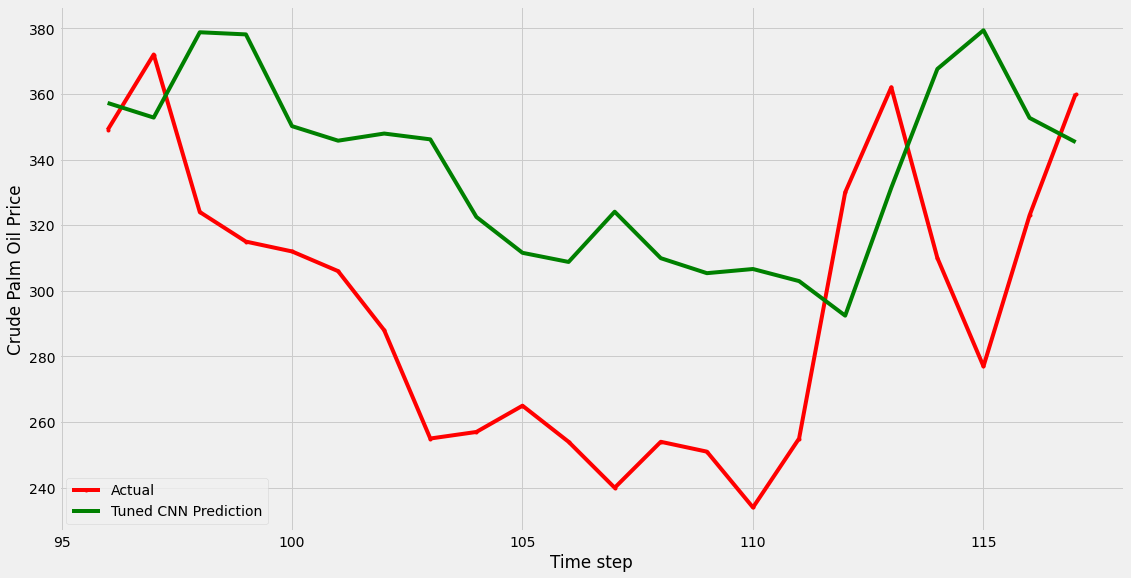

In [29]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluate CNN Model Accuracy

In [30]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 51.30838844992898
MDA value of the CNN Model is: 0.3333333333333333
MAPE value of the CNN Model is: 18.55097577305223
RMSE value of the CNN Model is: 56.327963582476194
MSE value of the CNN Model is: 3172.8394813487644


###Tuning CNN with Keras Tuner

Define A Model-Building Class

In [117]:
#class ANNhypermodel(HyperModel):
class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [118]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [119]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [120]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 1s 546ms/step - loss: 0.1623 - mae: 0.3871 - mse: 0.1623


####Random Search MSE = 0.2369

In [121]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 128,
 'units_3': 64,
 'units_4': 32,
 'dropout': 0.1,
 'optimizer': 'sgd',
 'activation': 'linear',
 'batch_size': 64,
 'epoch': 70,
 'momentum': 0.8700000000000001,
 'decay': 0.00010000100000000001,
 'learning_rate': 0.0010874771484415556}

###Build Bayesian Optimization

In [122]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [123]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 360ms/step - loss: 0.2290 - mae: 0.4630 - mse: 0.2290


###Bayesian Optimization Search MSE = 0.3562

###Evaluate Bayesian Optimization

In [124]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 96,
 'units_3': 32,
 'units_4': 24,
 'dropout': 0.0,
 'optimizer': 'adagrad',
 'batch_size': 88,
 'epoch': 60,
 'momentum': 0.8,
 'decay': 0.0009000010000000001,
 'learning_rate': 0.0014866048211473926,
 'activation': 'relu'}

In [125]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 441ms/step - loss: 0.2290 - mae: 0.4630 - mse: 0.2290


###Build HYPERBAND optimization

In [126]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [127]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [128]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


985.7413971424103  secs


In [129]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
fourth layer is {best_hps.get('units_4')}
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 96 
third layer is 64 
fourth layer is 16
drop out is 0.05
batch_size is 16
epoch is 80
optimizer is adagrad
activation is tanh

momentum is 0.8200000000000001
decay is 0.000500001

#learning rate is 0.004423920770740319                                        

and the optimal learning rate for the optimizer
is 0.004423920770740319.

[]
1/1 [==============================] - 0s 406ms/step - loss: 0.0122 - mae: 0.0959 - mse: 0.0122
loss:0.012198645621538162 mae: 0.09587270021438599 mse: 0.012198646552860737


In [59]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 160, 'units_2': 96, 'units_3': 48, 'units_4': 32, 'dropout': 0.35000000000000003, 'optimizer': 'adam', 'activation': 'sigmoid', 'batch_size': 72, 'epoch': 35, 'momentum': 0.8700000000000001, 'decay': 0.00010000100000000001, 'learning_rate': 0.0020428411416533315, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


###Apply the trained parameters to the CNN

In [130]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=160, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))

TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())


TUcnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))

#TUcnn_model.add(layers.Dropout(0.0))
TUcnn_model.add(tf.keras.layers.Dense(16, activation='tanh'))

#TUcnn_model.add(layers.Dropout(0.0))

#Output layer of model
TUcnn_model.add(tf.keras.layers.Dense(1))

In [132]:
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adagrad(lr=0.00442, decay = 0.00050), metrics= ['mae', 'mse'])
#TUcnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUcnn_model.fit(X_train, y_train, epochs=80, batch_size=16,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/80
5/5 [==============================] - 1s 79ms/step - loss: 0.0570 - mae: 0.1958 - mse: 0.0570 - val_loss: 0.0756 - val_mae: 0.2505 - val_mse: 0.0756
Epoch 2/80
5/5 [==============================] - 0s 14ms/step - loss: 0.0455 - mae: 0.1735 - mse: 0.0455 - val_loss: 0.0646 - val_mae: 0.2280 - val_mse: 0.0646
Epoch 3/80
5/5 [==============================] - 0s 18ms/step - loss: 0.0377 - mae: 0.1577 - mse: 0.0377 - val_loss: 0.0529 - val_mae: 0.2057 - val_mse: 0.0529
Epoch 4/80
5/5 [==============================] - 0s 17ms/step - loss: 0.0318 - mae: 0.1422 - mse: 0.0318 - val_loss: 0.0436 - val_mae: 0.1891 - val_mse: 0.0436
Epoch 5/80
5/5 [==============================] - 0s 16ms/step - loss: 0.0274 - mae: 0.1298 - mse: 0.0274 - val_loss: 0.0370 - val_mae: 0.1754 - val_mse: 0.0370
Epoch 6/80
5/5 [==============================] - 0s 17ms/step - loss: 0.0241 - mae: 0.1215 - mse: 0.0241 - val_loss: 0.0327 - val_mae: 0.1642 - val_mse: 0.0327
Epoch 7/80
5/5 [==================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

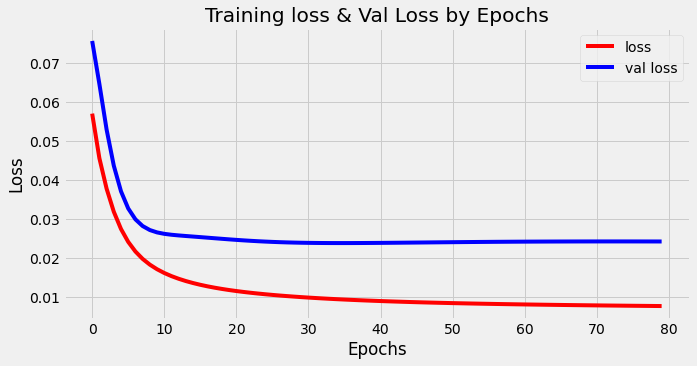

<Figure size 720x360 with 0 Axes>

In [133]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [134]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 106ms/step


array([[ 0.02321304],
       [ 0.00297157],
       [ 0.05245119],
       [ 0.02862353],
       [-0.02246363],
       [-0.05049166],
       [-0.0341959 ],
       [-0.05060415],
       [-0.09431464],
       [-0.15077466],
       [-0.13898757],
       [-0.10592762],
       [-0.14436617],
       [-0.16711031],
       [-0.16930015],
       [-0.17656165],
       [-0.19033834],
       [-0.189413  ],
       [-0.02016905],
       [ 0.05765171],
       [-0.01009976],
       [-0.0711612 ]], dtype=float32)

In [135]:
y_predTU.reshape(1,-1)

array([[ 0.02321304,  0.00297157,  0.05245119,  0.02862353, -0.02246363,
        -0.05049166, -0.0341959 , -0.05060415, -0.09431464, -0.15077466,
        -0.13898757, -0.10592762, -0.14436617, -0.16711031, -0.16930015,
        -0.17656165, -0.19033834, -0.189413  , -0.02016905,  0.05765171,
        -0.01009976, -0.0711612 ]], dtype=float32)

###Invert Transformed Tuned Data

In [136]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[328.28522 320.18863 339.98047 330.4494  310.01456 298.80334 305.32166
  298.75833 281.27414 258.69016 263.40497 276.62894 261.2535  252.15588
  251.27995 248.37535 242.86465 243.2348  310.93237 342.0607  314.96008
  290.53552]]


In [137]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [138]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [139]:
TU_CNN_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_CNN_Pred
TU_CNN_Pred

array([328.28522, 320.18863, 339.98047, 330.4494 , 310.01456, 298.80334,
       305.32166, 298.75833, 281.27414, 258.69016, 263.40497, 276.62894,
       261.2535 , 252.15588, 251.27995, 248.37535, 242.86465, 243.2348 ,
       310.93237, 342.0607 , 314.96008, 290.53552], dtype=float32)

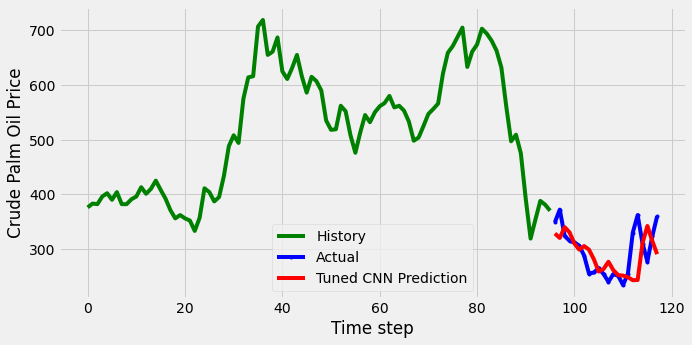

In [140]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [141]:
TUMAE_cnn = mean_absolute_error(y_test_inv, TU_CNN_Pred)
print('MAE value of the CNN Model is:', TUMAE_cnn)

TUMDA_cnn = mda(y_test_inv, TU_CNN_Pred)
print('MDA value of the CNN Model is:', TUMDA_cnn)

TUMAPE_cnn = mean_absolute_percentage_error(y_test_inv, TU_CNN_Pred)
print('MAPE value of the CNN Model is:', TUMAPE_cnn)

TURMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred, squared=False)
print('RMSE value of the CNN Model is:', TURMSE_cnn)

TUMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred)
print('MSE value of the CNN Model is:', TUMSE_cnn)

MAE value of the CNN Model is: 28.752182006835938
MDA value of the CNN Model is: 0.3333333333333333
MAPE value of the CNN Model is: 9.30629922812529
RMSE value of the CNN Model is: 42.18746906253871
MSE value of the CNN Model is: 1779.7825459026606


Compare tuned CNN Actual VS Predicted (Zoomed-IN)

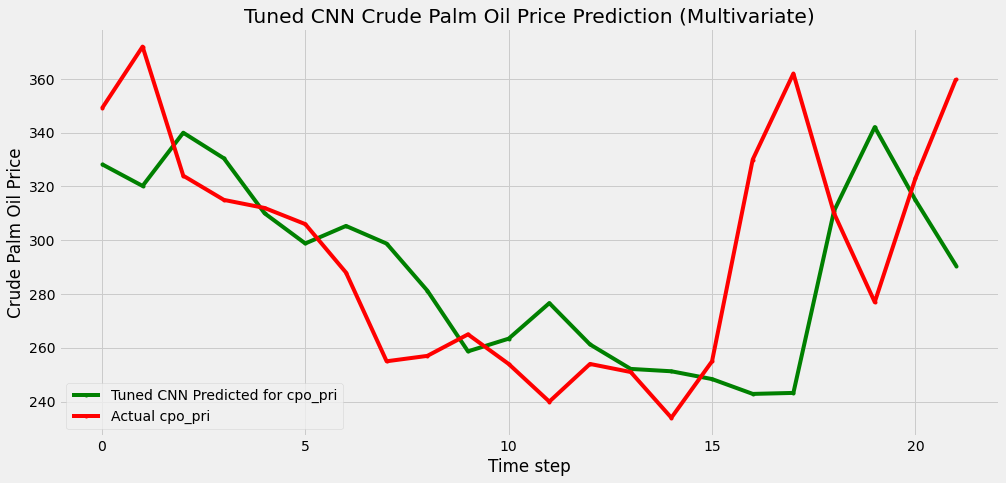

<Figure size 720x360 with 0 Axes>

In [142]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(15,7))  #(10,6))
plt.plot(TU_CNN_Pred, color= 'green',marker='.',label = 'Tuned CNN Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned CNN Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUcnn.png')

##Results

Baseline MSE         = 0.0160

Random search MSE    = 0.2349

Bayesian search MSE  = 0.3562

Hyperband search MSE = 0.0118

Baseline RSME        = 50.6

Tuned CNN RSME       = 42.18

The tuned CNN is superior to the basseline based on the RSME result

In [ ]:
TU_CNN_Pred

array([347.44516, 340.68094, 350.3727 , 349.47916, 338.25525, 325.55246,
       326.9378 , 325.72952, 309.97247, 299.66055, 303.72882, 307.1458 ,
       296.03058, 283.43015, 286.5078 , 285.74634, 274.33182, 275.08328,
       328.6628 , 367.21143, 348.66684, 324.47903], dtype=float32)

In [ ]:
df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index=False

In [ ]:
dataframe=pd.DataFrame(TU_CNN_Pred, columns=['CNN_tuned']) 
print (dataframe)

df.to_csv('TU_CNN_Pred.csv', index = False)

     CNN_tuned
0   347.445160
1   340.680939
2   350.372711
3   349.479156
4   338.255249
5   325.552460
6   326.937805
7   325.729523
8   309.972473
9   299.660553
10  303.728821
11  307.145813
12  296.030579
13  283.430145
14  286.507812
15  285.746338
16  274.331818
17  275.083282
18  328.662811
19  367.211426
20  348.666840
21  324.479034


In [ ]:
df = pd.DataFrame(TU_CNN_Pred)

In [ ]:

import pandas as pd

data = {'product': ['computer', 'tablet', 'printer', 'laptop'],
        'price': [850, 200, 150, 1300]
        }

df = pd.DataFrame(data)

print(df)

    product  price
0  computer    850
1    tablet    200
2   printer    150
3    laptop   1300


In [ ]:
df = pd.DataFrame(TU_CNN_Pred)

print(df)

             0
0   347.445160
1   340.680939
2   350.372711
3   349.479156
4   338.255249
5   325.552460
6   326.937805
7   325.729523
8   309.972473
9   299.660553
10  303.728821
11  307.145813
12  296.030579
13  283.430145
14  286.507812
15  285.746338
16  274.331818
17  275.083282
18  328.662811
19  367.211426
20  348.666840
21  324.479034


In [ ]:
r‘C:/content/TU_CNN_Pred.csv‘

SyntaxError: ignored

In [ ]:
/content/TU_CNN_Pred.csv